In [1]:
from astropy.coordinates import SkyCoord, get_sun, get_moon, EarthLocation, AltAz
from astropy.time import Time
from astropy.table import Table, Column
import astropy.units as u
import numpy as np
from astropy import constants as c
from fils import *
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import root
from matplotlib.dates import DateFormatter
from astroplan.moon import moon_illumination
from astroplan.plots import plot_finder_image
import datetime

In [2]:
timediff = 10.0
utcplus = 2.0
filename = 'testlist.txt'
FC = True
fov = 10.0
retic = True

In [3]:
master = Table.read(('RESULTS/'+filename), format='ascii.csv')

In [4]:
date, observatory, civang, amlim, astrang, extra = list(master[0])
civang = float(civang.strip('deg'))
amlim = float(amlim)
astrang = float(astrang.strip('deg'))
master.remove_row(0)

In [5]:
coos = SkyCoord(ra=master['RA'], dec=master['Dec'], frame='icrs', unit=(u.hourangle, u.deg))
coocol = Column(coos, name='Coordinate')
master.add_column(coocol)

In [6]:
Fv=np.multiply(np.multiply(3631.0, np.power(10.0, np.negative(np.divide(np.array(master['AB_Mag']).astype(float), 2.5)))), np.power(10.0, -23.0))
FvCol = Column(Fv, name='Fv')
master.add_column(FvCol)

In [7]:
Fl = []
for i in range(0, len(master)):
    Fl.append(np.multiply(np.divide((c.c.to(u.angstrom/u.s)).value, np.power(effwav(master['Filter'][i]), 2.0)), master['Fv'][i]))
FlCol = Column(Fl, name='Fl')
master.add_column(FlCol)

In [8]:
master.show_in_notebook()

idx,Name,RA,Dec,Extent,AB_Mag,Filter,Coordinate,Fv,Fl
0,J0002+6216,00:02:58.17,+62:16:09.4,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (0.742375, 62.26927778)>",3.6310000000000003e-28,2.803699404103416e-17
1,J0006+1834,00:06:04.8,+18:34:59,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (1.52, 18.58305556)>",3.6310000000000003e-28,2.803699404103416e-17
2,J0007+7303,00:07:01.7,+73:03:07.4,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (1.75708333, 73.05205556)>",3.6310000000000003e-28,2.803699404103416e-17
3,J0011+08,00:11:34,+08:10:00,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (2.89166667, 8.16666667)>",3.6310000000000003e-28,2.803699404103416e-17
4,J0014+4746,00:14:17.75,+47:46:33.4,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (3.57395833, 47.77594444)>",3.6310000000000003e-28,2.803699404103416e-17
5,J0023+0923,00:23:16.88,+09:23:23.8652,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (5.82033333, 9.38996256)>",3.6310000000000003e-28,2.803699404103416e-17
6,J0024-7201Z,00:24:06.04,-72:05:01.480,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (6.02516667, -72.08374444)>",3.6310000000000003e-28,2.803699404103416e-17
7,J2330-2005,23:30:26.89,-20:05:29.63,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (352.61204167, -20.09156389)>",3.6310000000000003e-28,2.803699404103416e-17
8,J2333+6145,23:33:19.45,+61:45:30.09,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (353.33104167, 61.75835833)>",3.6310000000000003e-28,2.803699404103416e-17
9,J2337+6151,23:37:05.76,+61:51:01.53,P,20.0,r',"<SkyCoord (ICRS): (ra, dec) in deg (354.274, 61.850425)>",3.6310000000000003e-28,2.803699404103416e-17


In [9]:
obslat, obslon, obsheight = observatoryephem(observatory)
observatoryloc = EarthLocation(lat=obslat*u.deg , lon=obslon*u.deg , height=obsheight*u.m)

In [10]:
if date=='today':
    date=datetime.datetime.utcnow()
    date = date.strftime('%Y-%m-%d')
    
probedate = Time(date+'T23:59:59', format='isot', scale='utc')
probedate = probedate+(np.linspace(-timediff, timediff, 1000)*u.hour)
probesunaltaz = get_sun(probedate).transform_to(AltAz(obstime=probedate, location=observatoryloc))

In [11]:
probearray = []
for i in probesunaltaz:
    probearray.append(i.alt.degree)
    
probeinterp = interp1d(range(0,len(probearray)), probearray)
roots = root(probeinterp, [100, len(probearray)-100])
nr = np.rint(roots.x).astype(int)
ssind = nr[0]
srind = nr[1]

cvprobeint = interp1d(range(0,len(probearray)), np.add(probearray, civang))
roots = root(cvprobeint, [100, len(probearray)-100])
nr = np.rint(roots.x).astype(int)
cvtwind = nr[0]
cvbdind = nr[1]

astrprobeint = interp1d(range(0,len(probearray)), np.add(probearray, astrang))
roots = root(astrprobeint, [100, len(probearray)-100])
nr = np.rint(roots.x).astype(int)
astrtwind = nr[0]
astrbdind = nr[1]

In [12]:
tss = probedate[ssind]
tct = probedate[cvtwind]
tat = probedate[astrtwind]
tad = probedate[astrbdind]
tcd = probedate[cvbdind]
tsr = probedate[srind]
tmn = tss+((tsr-tss).to(u.h))/2.0
print('Sunset:\t', tss)
print('Civil Twilight:\t', tct)
print('Astronomical Twilight:\t', tat)
print('Midnight:\t', tmn)
print('Astronomical Dawn:\t', tad)
print('Civil Dawn:\t', tcd)
print('Sunrise:\t', tsr)

Sunset:	 2018-12-25T15:09:39.180
Civil Twilight:	 2018-12-25T15:42:05.126
Astronomical Twilight:	 2018-12-25T16:44:32.874
Midnight:	 2018-12-25T22:20:53.054
Astronomical Dawn:	 2018-12-26T03:56:01.162
Civil Dawn:	 2018-12-26T04:58:28.910
Sunrise:	 2018-12-26T05:32:06.928


<Figure size 432x288 with 0 Axes>

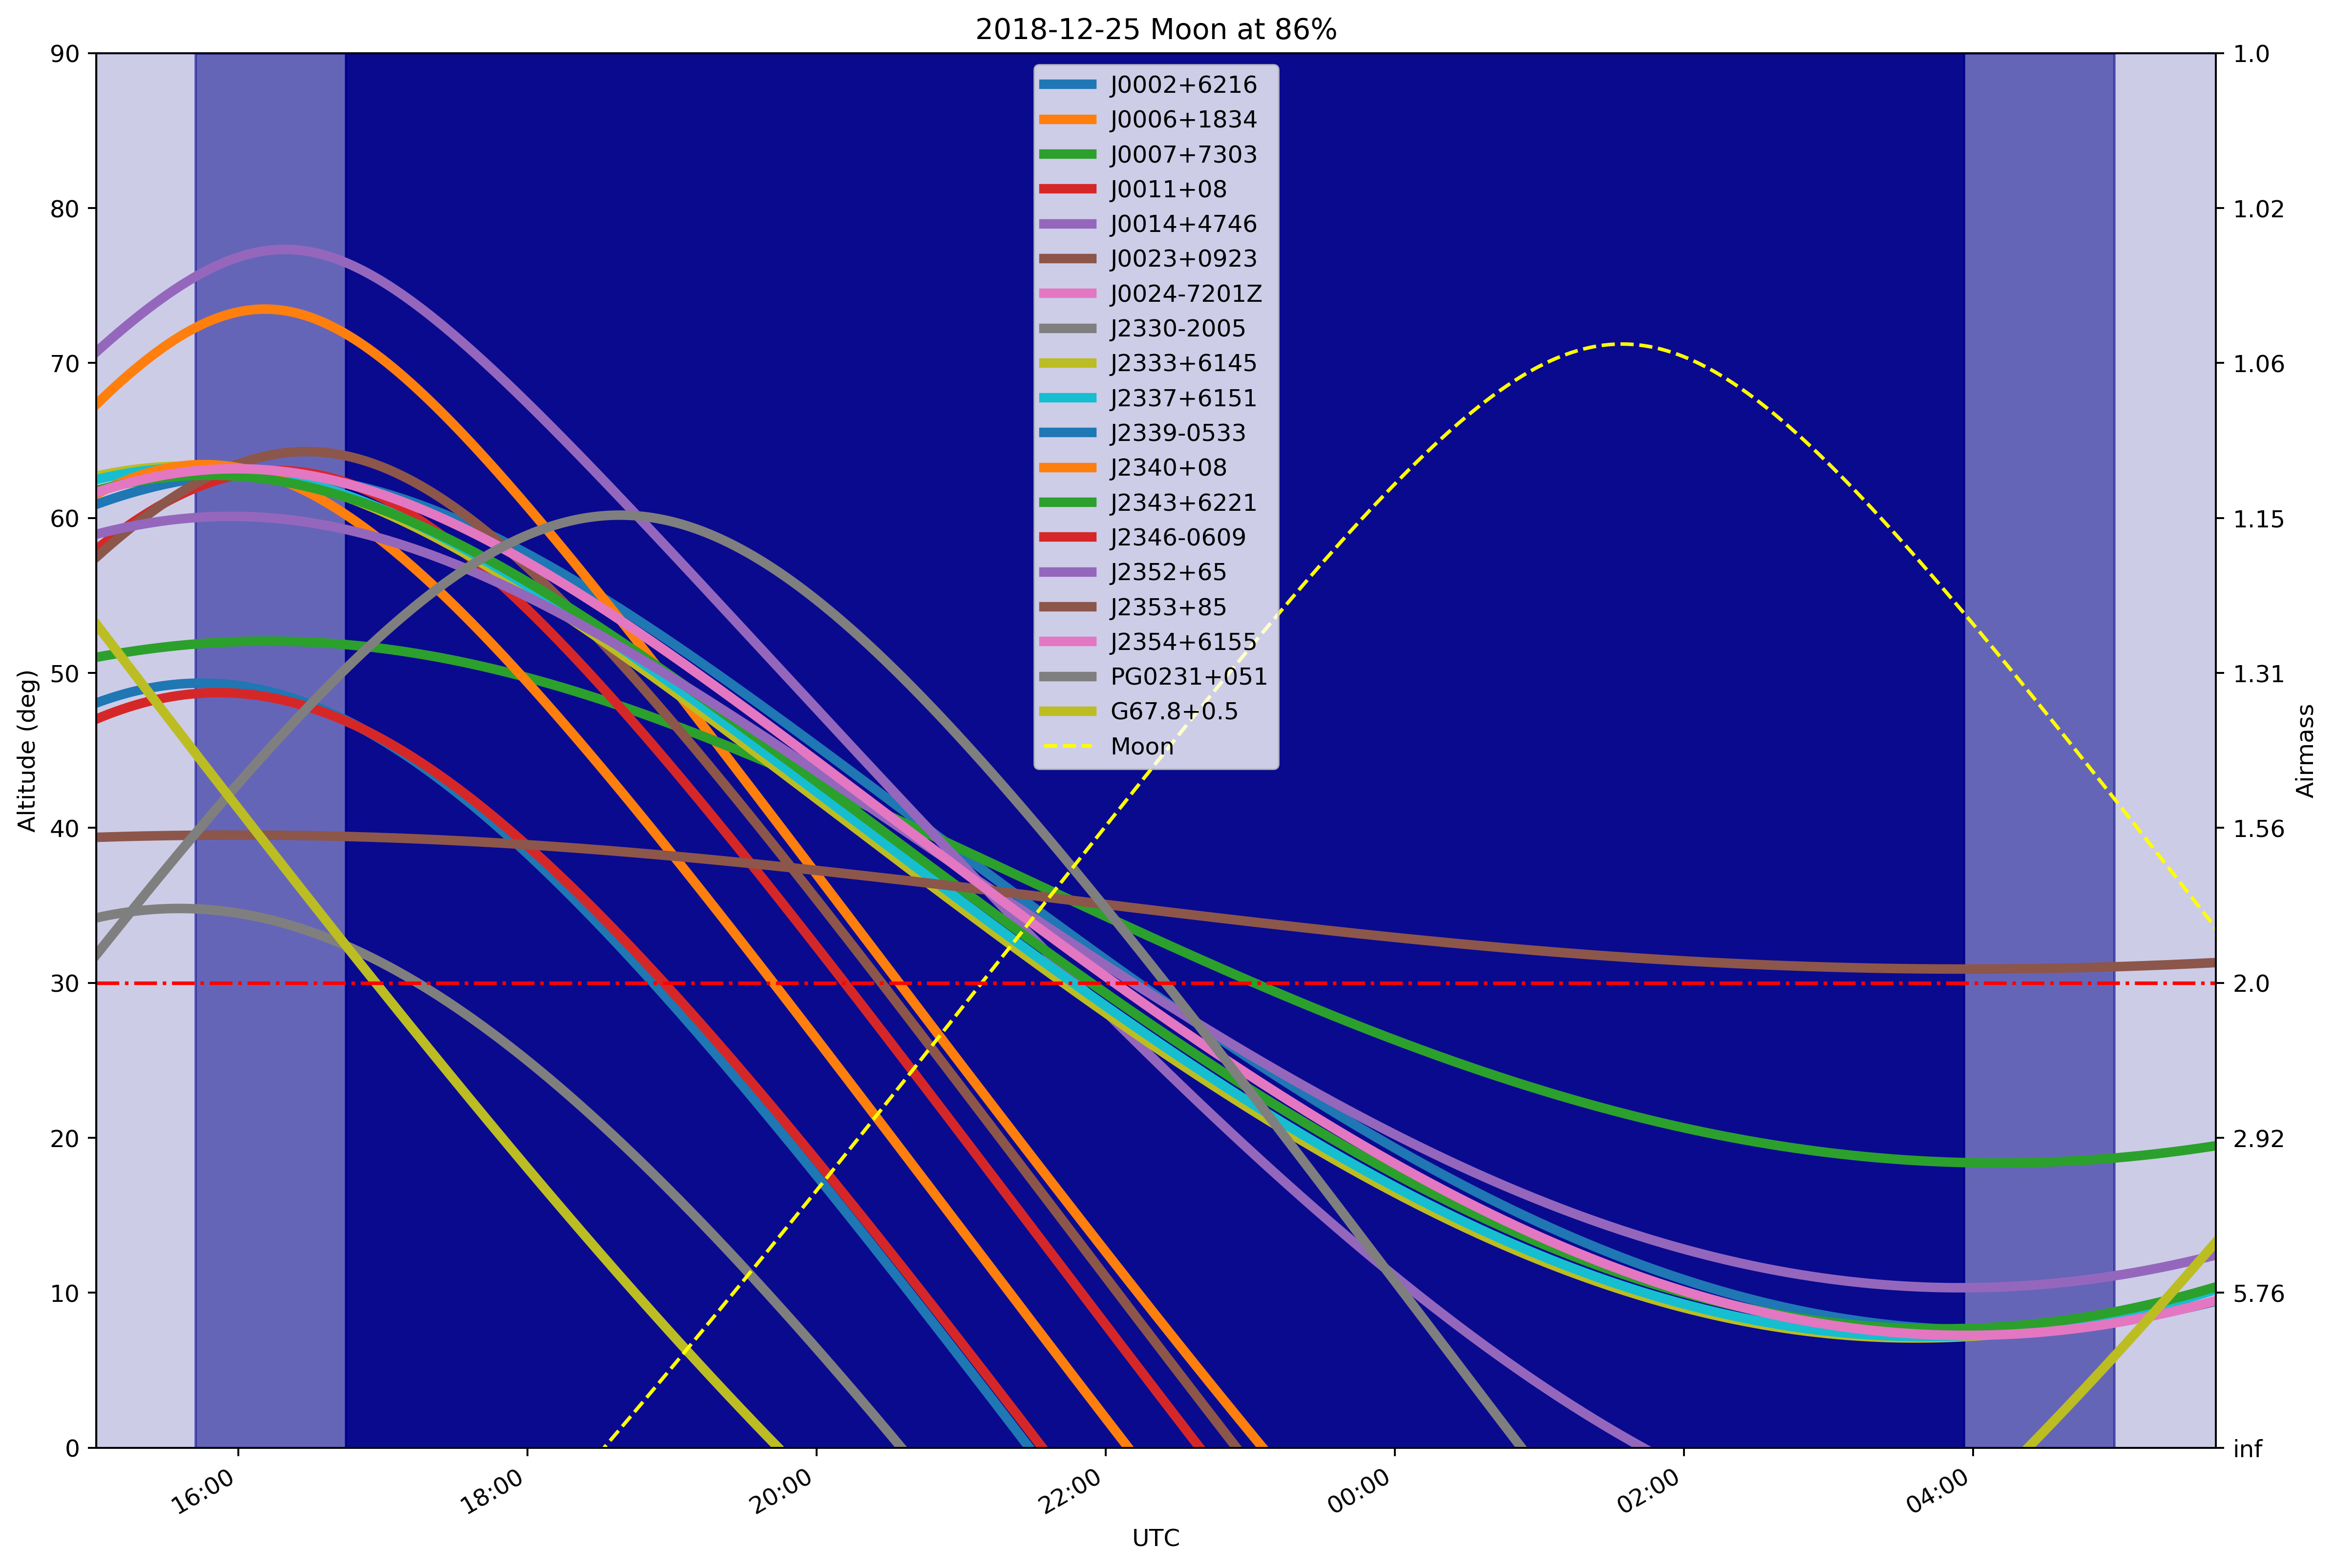

In [13]:
times = np.array([((i/1000.0)*(tsr-tss)).to(u.h).value for i in range(-10, 1011)])*u.hour
times = tss + times
sunaltaz = get_sun(times).transform_to(AltAz(obstime=times, location=observatoryloc))
moonaltaz = get_moon(times).transform_to(AltAz(obstime=times, location=observatoryloc))
millum = int(np.rint(moon_illumination(tss+((tsr-tss).to(u.h))/2.0)*100))
plt.clf()
fig = plt.figure(dpi=350, figsize=(16, 12), facecolor='white')
ax = fig.add_subplot(111)
# ax.plot_date(times.plot_date, sunaltaz.alt.deg, fmt='-', xdate=True, label='Sun')
for i in master:
    objaltaz = i['Coordinate'].transform_to(AltAz(obstime=times, location=observatoryloc))
    nameof = i['Name']
    ax.plot_date(times.plot_date, objaltaz.alt.deg, fmt='-', xdate=True, label=nameof, lw=4)
if extra=='Moon':
    ax.plot_date(times.plot_date, moonaltaz.alt.deg, fmt='--', color='yellow', xdate=True, label='Moon')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_xlabel('UTC')
ax.set_ylabel('Altitude (deg)')
ax.set_ylim(0,90)
ax.set_xlim(times[0].plot_date, times[-1].plot_date)
ax.axvspan(times[0].plot_date, times[-1].plot_date, color='darkblue', alpha=0.2, zorder=0)
ax.axvspan(tct.plot_date, tcd.plot_date, color='darkblue', alpha=0.5, zorder=1)
ax.axvspan(tat.plot_date, tad.plot_date, color='darkblue', alpha=0.9, zorder=2)
# def advtim(inlab):
#     inlab = np.array(inlab).astype(float)
#     return np.add(inlab, utcplus*(1.0/(24.0)))
def alt2am(alt):
    inlab = np.array(alt).astype(float)
    toret = np.around(np.divide(1.0, np.cos(np.deg2rad(np.subtract(90.0, inlab)))), decimals=2)
    toretn = [x if x<100 else 'inf' for x in toret]
    return toretn
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.xaxis_date()
# ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))
# ax2.set_xticklabels(advtim(ax.get_xticks()))
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels(alt2am(ax.get_yticks()))
ax2.set_ylabel('Airmass')
limlin = 90.0-np.rad2deg(np.arccos(1.0/amlim))
ax.axhline(y=limlin, color='red', linestyle='-.')
plt.gcf().autofmt_xdate()
ax.legend()
ax.set_title(date + ' Moon at %d%%' % millum)
plt.savefig('AMPLOT.png')

In [14]:
filer = open('ALMANAC.txt', 'w')
filer.write('Sunset:\t\t\t\t\t'+ tss.iso[:-7] + '\n')
filer.write('Civil Twilight:\t\t\t'+ tct.iso[:-7] + '\n')
filer.write('Astronomical Twilight:\t'+ tat.iso[:-7] + '\n')
filer.write('Midnight:\t\t\t\t'+ tmn.iso[:-7] + '\n')
filer.write('Astronomical Dawn:\t\t'+ tad.iso[:-7] + '\n')
filer.write('Civil Dawn:\t\t\t\t'+ tcd.iso[:-7] + '\n')
filer.write('Sunrise:\t\t\t\t'+ tsr.iso[:-7] + '\n')
filer.close()

<Figure size 432x288 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

<Figure size 5600x4200 with 0 Axes>

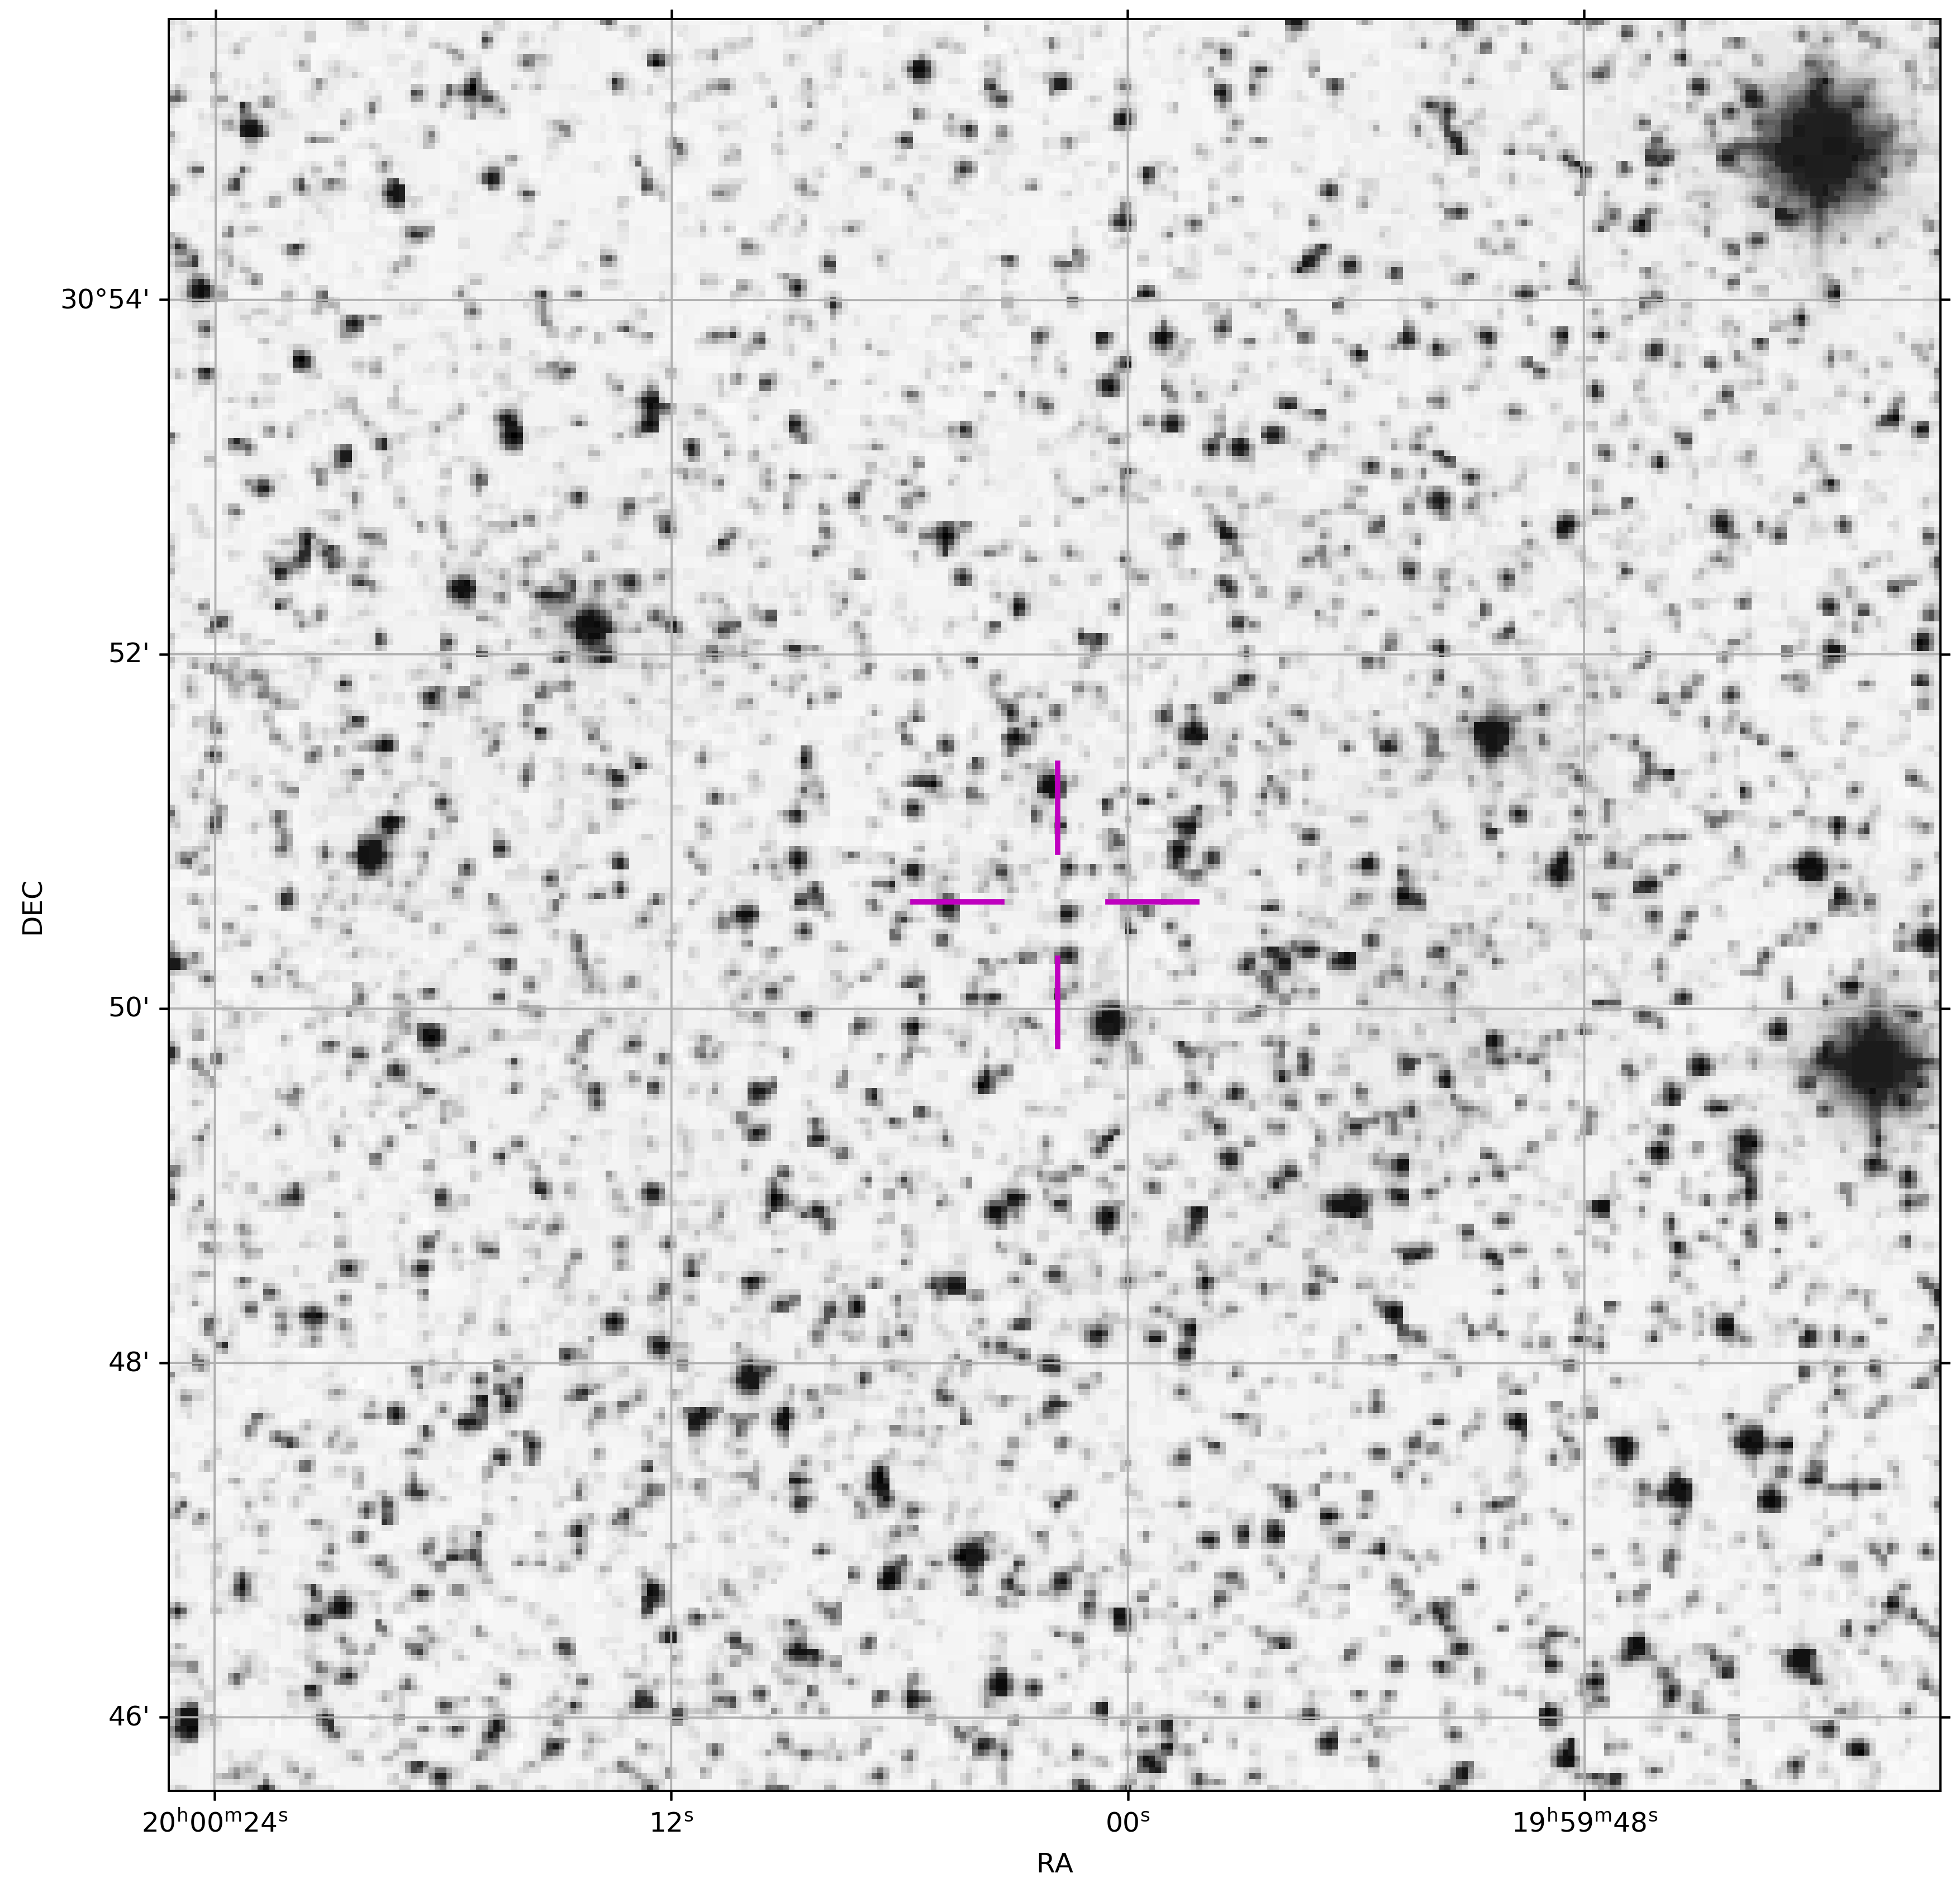

In [15]:
if fov:
    fov=float(fov)*u.arcmin
else:
    fov=10.0*u.arcmin

if not retic:
    retic=False

if FC:
    for i in master:
        plt.clf()
        plt.figure(dpi=350, figsize=(16, 12), facecolor='white')
        ax, hdu = plot_finder_image(i['Coordinate'], reticle=retic, fov_radius=fov)
        plt.savefig('RESULTS/FC/'+i['Name']+'.png')